In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, truncnorm, cauchy

# Parameters for data
n = 30
m = 0  # Mean of data-generating distribution
s = 1  # Standard deviation of data-generating distribution
x = norm(loc=m, scale=s).rvs(size=n)  # Generate data

# Prior hyperparameters
theta_0 = 1.0  # Center of Cauchy prior
gamma_theta = 1.0  # Scale parameter of Cauchy prior
alpha = 2.0    # Shape parameter for Gamma prior on tau
lambd = 1.0    # Rate parameter for Gamma prior on tau
proposal_s = 0.5  # Scale parameter for truncated normal proposal

# Gibbs sampler settings
C = 2       # Number of chains
G = 100     # Number of samples
theta = np.zeros((C, G))  # Storage for theta samples
tau = np.zeros((C, G))    # Storage for tau samples


In [5]:
# Initialization
theta[:, 0] = theta_0
tau[:, 0] = lambd

for c in range(C):  # Loop over chains
    for g in range(1, G):
        # Sample theta | tau, x from the Cauchy prior and likelihood
        tau_post = tau[c, g-1]
        mean_theta = (n * np.mean(x) * tau_post) / (n * tau_post)  # Simplified with non-normal prior
        theta_proposal = cauchy(loc=theta_0, scale=gamma_theta).rvs()  # Sample from Cauchy
        
        # Sample tau | theta, x using a dependent truncated normal proposal
        tau_current = tau[c, g-1]
        a, b = (-tau_current / proposal_s, np.inf)  # Lower and upper bounds
        tau_proposal = truncnorm(a=a, b=b, loc=tau_current, scale=proposal_s).rvs()
        
        # Calculate the log of the joint posterior
        log_posterior_proposal = (
            -0.5 * tau_proposal * np.sum((x - theta_proposal)**2)
            + (alpha - 1) * np.log(tau_proposal) - lambd * tau_proposal
        )
        log_posterior_current = (
            -0.5 * tau_current * np.sum((x - theta[c, g-1])**2)
            + (alpha - 1) * np.log(tau_current) - lambd * tau_current
        )

        # Calculate acceptance ratio
        acceptance_ratio = np.exp(log_posterior_proposal - log_posterior_current)

        # Accept or reject the proposal
        if np.random.uniform(0, 1) < acceptance_ratio:
            tau[c, g] = tau_proposal
        else:
            tau[c, g] = tau_current
        
        # Store theta proposal for this iteration
        theta[c, g] = theta_proposal

# Burn-in period
burn = 20


/tmp/ipykernel_190/2204964086.py:28: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(log_posterior_proposal - log_posterior_current)


In [7]:
# Calculate credible intervals for theta and tau
theta_samples = theta[:, burn:].flatten()
tau_samples = tau[:, burn:].flatten()
credible_level = 0.95

# Credible interval for theta
theta_lower = np.percentile(theta_samples, (1 - credible_level) / 2 * 100)
theta_upper = np.percentile(theta_samples, (1 + credible_level) / 2 * 100)

# Credible interval for tau
tau_lower = np.percentile(tau_samples, (1 - credible_level) / 2 * 100)
tau_upper = np.percentile(tau_samples, (1 + credible_level) / 2 * 100)

print(tau_lower, ",", tau_upper)

0.008656584826478173 , 2.615636426074732


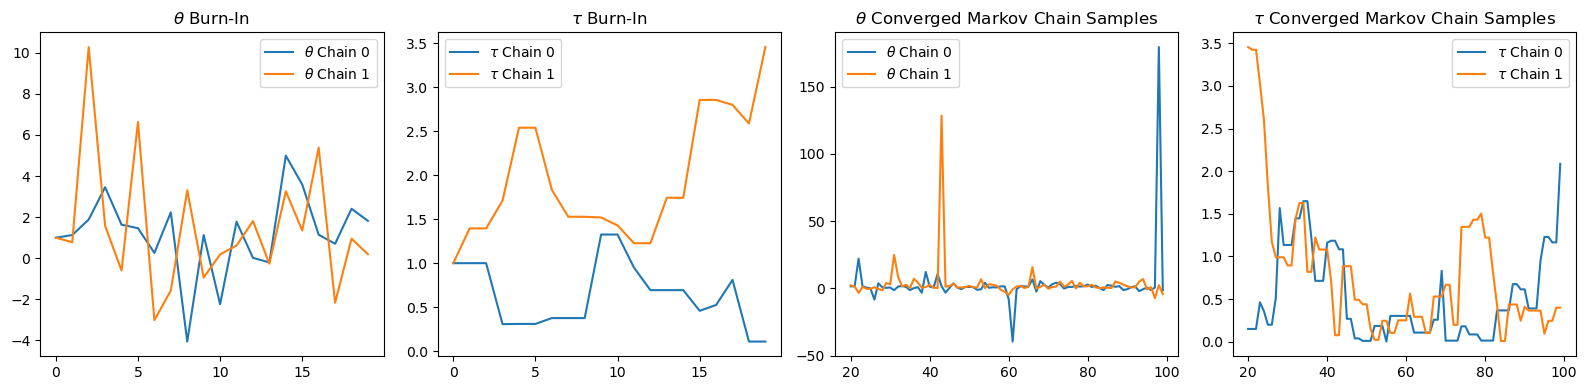

In [8]:
# Visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain Samples")

for c in range(C):
    # Burn-in period
    ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c}")
    ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c}")
    
    # Stationary samples
    ax[2].plot(np.arange(burn, G), theta[c, burn:], label=f"$\\theta$ Chain {c}")
    ax[3].plot(np.arange(burn, G), tau[c, burn:], label=f"$\\tau$ Chain {c}")

for a in ax:
    a.legend()

plt.tight_layout()
plt.show()